### Install Libraries

In [1]:
%pip install pandas
%pip install TroPyCal
%pip install geopy
%pip install folium
%pip install numpy
%pip install matplotlib
%pip install sklearn
%pip install geopandas
%pip install datetime
%pip install cartopy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 52.6/52.6 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import/Load Libraries

In [10]:
from tropycal import tracks #importing the dataset of storms tracks
import pandas as pd #TO support dataframes
from geopy.geocoders import Nominatim #nominatim to allow geocoding
import folium #for interactive map for visualization
import numpy as np #for array operations
import matplotlib.pyplot as plt #visualize and plot data
from sklearn.neighbors import KernelDensity #used to estimate proability density data
import geopandas as gpd #To handle geospatial data
from datetime import datetime
import cartopy.crs as ccrs # for map of hurricane density
import cartopy.feature as cfeature

### Find latitudes and longitudes of given cities

In [6]:
#load csv Gulf_Cities into a dataframe
df = pd.read_csv('Gulf_Cities.csv', encoding = "latin1")

#intialize the geocoder
geolocator = Nominatim(user_agent="city_locator")

#function to get the latitude and longitude of a city
def get_latitude_longitude(city):
    location = geolocator.geocode(city) #if the city can be located
    if location:
        return location.latitude, location.longitude #return the latitude and longtidue 
    else:
        return None, None #if not, then nothing is returned

#Creates latitude and longitude columns in the dataframe and inputs output from function to it
df['Latitude'], df['Longitude'] = zip(*df['City Name'].apply(get_latitude_longitude)) #zip to seperate the lat/lon tuples into seperate lists

print(df)

            City Name          Country   Latitude   Longitude
0         New Orleans              USA  29.975998  -90.078213
1             Houston              USA  29.758938  -95.367697
2               Tampa              USA  27.947760  -82.458444
3               Miami              USA  25.774173  -80.193620
4      Corpus Christi              USA  27.763530  -97.403319
5           Pensacola              USA  30.421309  -87.216915
6              Mobile              USA  30.691346  -88.043751
7           Galveston              USA  29.305700  -94.793325
8              Biloxi              USA  30.400763  -88.889382
9            Key West              USA  24.554826  -81.802072
10           Veracruz           Mexico  19.333333  -96.666667
11            Tampico           Mexico  22.215762  -97.857771
12           Campeche           Mexico  19.000000  -90.500000
13             Cancún           Mexico  21.152747  -86.842576
14             Mérida           Mexico  38.917467   -6.344398
15  Ciud

### Filter dataset so it's only storms from past 25 years that hit the Gulf of Mexico

In [7]:
dataset= tracks.TrackDataset(basin="north_atlantic")
#Approximation of the borders for the gulf of Mexico
gulf_of_mexico_domain = {
    "n": 30.0,   #northern latitude
    "s": 18.0,   #southern latitude
    "e": -81.0,  #eastern longitude
    "w": -98.0   #western longitude
}

#Filter storms so its only ones that hit/go through the gulf in the past 25 years
gulf_storms = dataset.filter_storms(domain=gulf_of_mexico_domain, year_range=(1999, 2024)) #this is a list of only the identifiers of the storms

print(gulf_storms)


--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (4.85 seconds)
['AL012000', 'AL012001', 'AL012005', 'AL012006', 'AL012008', 'AL012010', 'AL012011', 'AL012013', 'AL012018', 'AL021999', 'AL022002', 'AL022004', 'AL022005', 'AL022007', 'AL022010', 'AL022013', 'AL022015', 'AL022019', 'AL022023', 'AL031999', 'AL032001', 'AL032003', 'AL032004', 'AL032005', 'AL032010', 'AL032016', 'AL032017', 'AL032020', 'AL032021', 'AL042001', 'AL042003', 'AL042005', 'AL042007', 'AL042008', 'AL042009', 'AL042011', 'AL042012', 'AL042016', 'AL052000', 'AL052002', 'AL052005', 'AL052007', 'AL052008', 'AL052010', 'AL052012', 'AL052014', 'AL052016', 'AL052021', 'AL062002', 'AL062004', 'AL062006', 'AL062008', 'AL062013', 'AL062017', 'AL062021', 'AL071999', 'AL072005', 'AL072008', 'AL072012', 'AL072017', 'AL072018', 'AL072019', 'AL072021', 'AL082001', 'AL082003', 'AL082011', 'AL082013', 'AL082020', 'AL092000', 'AL092002', 'AL092004', 'AL092007', 'AL092008', 'AL092012', 'AL092014', 'AL092016

### Filter data further to only include storms that reached hurricane status and make a list that contains all the data about each hurricane

In [8]:
#make empty list that will only accept Hurricane status storms
full_storm_datasets = []

#for-loop to iterate through all the storms using their ID
for storm_name in gulf_storms:
    #Retrieve the full storm dataset for each storm by its ID
    storm_data = dataset.get_storm(storm_name)

    #Check if the storm ever became a Hurricane (HU)
    storm_types = storm_data["type"]

    if "HU" in storm_types:
        full_storm_datasets.append(storm_data)  #Add it to the list if the storm reached Hurricane status

#full_storm_datasets is a list with only Hurricane status storms
print(full_storm_datasets)  #Print each storm and their attributes


[<tropycal.tracks.Storm>
Storm Summary:
    Maximum Wind:      95 knots
    Minimum Pressure:  946 hPa
    Start Time:        1800 UTC 25 June 2010
    End Time:          0000 UTC 02 July 2010

Variables:
    time        (datetime) [2010-06-24 18:00:00 .... 2010-07-02 00:00:00]
    extra_obs   (int32) [0 .... 0]
    special     (str) [ .... ]
    type        (str) [LO .... TD]
    lat         (float64) [15.9 .... 23.2]
    lon         (float64) [-82.0 .... -101.9]
    vmax        (int32) [25 .... 30]
    mslp        (int32) [1007 .... 997]
    wmo_basin   (str) [north_atlantic .... north_atlantic]

More Information:
    id:              AL012010
    operational_id:  AL012010
    name:            ALEX
    year:            2010
    season:          2010
    basin:           north_atlantic
    source_info:     NHC Hurricane Database
    source:          hurdat
    ace:             7.7
    realtime:        False
    invest:          False
    subset:          False, <tropycal.tracks.Storm>

### Visualize the storms and their tracks

In [ ]:
#Makes map around Gulf Of Mexico
gulf_map = folium.Map(location=[24.0, -90.0], zoom_start=6)

#Loop through all hurricanes and put their track data on the map
for storm_data in full_storm_datasets:
    latitudes = storm_data['lat']  #latitude data
    longitudes = storm_data['lon']  #Longitude data
    
    #Turn a storms track into a line on the map
    storm_track = list(zip(latitudes, longitudes)) #zip needed to make 2 sperate lists of latitudes and longitudes of the storm
    folium.PolyLine(storm_track, color='blue', weight=2.5, opacity=1).add_to(gulf_map) #make line
    
    #this is to visualize the end of the storms path
    folium.Marker(location=[latitudes[-1], longitudes[-1]], popup=f"{storm_data['name']} End").add_to(gulf_map)

#Save the map as an html file to visualize
gulf_map.save('gulf_storms_map.html')

### Risk assessment

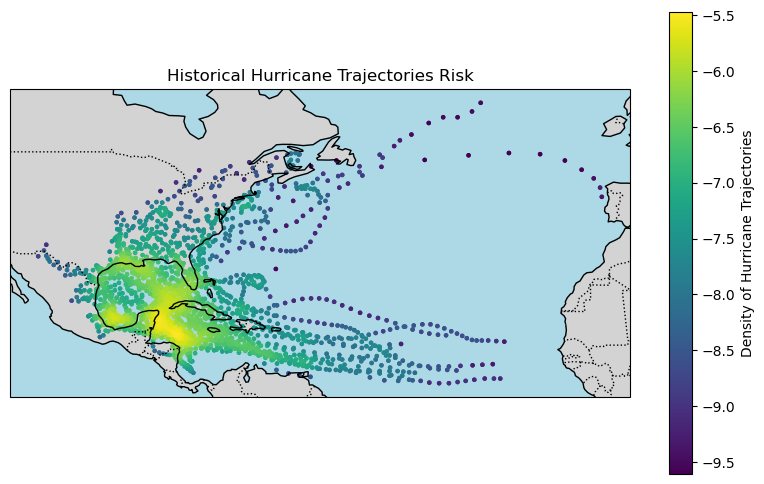

Spatial Correlation between ENSO (ONI) and Hurricane Density: 0.13830968241324276
Spatial Correlation between SST and Hurricane Density: -0.1653041968092077


<Figure size 1000x600 with 0 Axes>

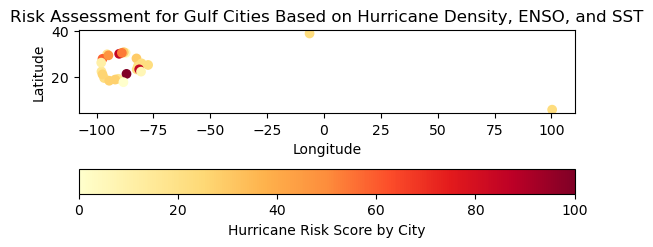

City: New Orleans, Risk Score: 85.26932718912968
City: Houston, Risk Score: 18.195072343862577
City: Tampa, Risk Score: 29.33815772709569
City: Miami, Risk Score: 22.090171716262134
City: Corpus Christi, Risk Score: 58.81242546150012
City: Pensacola, Risk Score: 6.610764968034644
City: Mobile, Risk Score: 29.16406415307445
City: Galveston, Risk Score: 47.338434989875424
City: Biloxi, Risk Score: 53.822501717918854
City: Key West, Risk Score: 21.16691529929075
City: Veracruz, Risk Score: 21.555988398616392
City: Tampico, Risk Score: 16.779508770516188
City: Campeche, Risk Score: 16.779508770516188
City: Cancún, Risk Score: 100.0
City: Mérida, Risk Score: 22.680256492005498
City: Ciudad del Carmen, Risk Score: 27.638372990376453
City: Progreso, Risk Score: 10.958296121335835
City: Coatzacoalcos, Risk Score: 27.638372990376453
City: Tuxpan, Risk Score: 26.270089693244103
City: Havana, Risk Score: 21.16691529929075
City: Varadero, Risk Score: 84.52871384268127
City: Cienfuegos, Risk Score:

In [11]:
#Load ENSO/SST data from csv
enso_sst_data = pd.read_csv("ENSO.csv")

# Clean the column names and filter for the past 25 years
enso_sst_data.columns = enso_sst_data.columns.str.strip()  # Remove any leading/trailing spaces from columns
enso_sst_data = enso_sst_data[enso_sst_data['Year'] >= 1999]

#Convert the 'Date' column to datetime format (MM/DD/YYYY format)
enso_sst_data['Date'] = pd.to_datetime(enso_sst_data['Date'], format='%m/%d/%Y', errors='coerce')

#Handle missing values
enso_sst_data_cleaned = enso_sst_data.dropna(subset=['Nino 1+2 SST', 'Nino 3 SST', 'Nino 3.4 SST', 'ONI', 'Global Temperature Anomalies'])

#Calculate monthly ENSO and SST averages
monthly_enso_sst = enso_sst_data_cleaned.groupby('Month')[['Nino 1+2 SST', 'Nino 3 SST', 'Nino 3.4 SST', 'ONI', 'Global Temperature Anomalies']].mean()

#Calculate correlation between ENSO phases and SST anomalies
oni_values = monthly_enso_sst['ONI']
sst_values = monthly_enso_sst['Global Temperature Anomalies']

# Gather all storm latitude and longitude points for KDE density estimation
storm_latitudes = []
storm_longitudes = []
storm_ids = []  #List to store the storms

#iterate through all storm datasets
for storm in full_storm_datasets:
    storm_latitudes.extend(storm['lat'])
    storm_longitudes.extend(storm['lon'])
    storm_ids.extend([storm.id] * len(storm['lat']))  #Add the storm ID for each latitude-longitude point

#Perform KDE on latitude and longitude data for density estimation
xy = np.vstack([storm_longitudes, storm_latitudes])
kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(xy.T)
density = kde.score_samples(xy.T)

#Map density to storm IDs (for accessing density values later)
storm_density_map = {storm.id: density[idx] for idx, storm in enumerate(full_storm_datasets)}

# Create a map plot for hurricane trajectory density
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
# Add map features for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.OCEAN, color='lightblue')
# Plot density on map with scatter plot of latitudes and longitudes
scatter = ax.scatter(storm_longitudes, storm_latitudes, c=density, s=5, cmap='viridis', transform=ccrs.PlateCarree())
plt.scatter(storm_longitudes, storm_latitudes, c=density, s=5, cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(scatter, label='Density of Hurricane Trajectories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Historical Hurricane Trajectories Risk')
plt.show()

month_abbr = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'] #list of months in abbreviation form

#Initialize lists to collect data for correlation analysis
monthly_hurricane_density = []
monthly_oni_values = []
monthly_sst_values = []

#Loop through each month
for i, month in enumerate(month_abbr): 
    if month in monthly_enso_sst.index:  #Check if the month exists in the ENSO/SST data
        #Extract the relevant ONI and SST values for the current month
        oni_value = monthly_enso_sst.loc[month, 'ONI']
        sst_value = monthly_enso_sst.loc[month, 'Global Temperature Anomalies']
        
        # Gather the density values for hurricanes that occurred in the same month
        storm_density_for_month = []
        for storm_data in full_storm_datasets:
            # Check if the storm has a 'time' attribute (datetime object)
            if hasattr(storm_data, 'time'):
                # Extract the months from all the times associated with this storm
                storm_months = [t.month for t in storm_data.time]

                # Check if any of the storm's time entries fall in the current month
                if (i + 1) in storm_months:  # i + 1 gives the correct month number (1-12)
                    # Add the corresponding hurricane density for this storm to the list
                    storm_density_for_month.append(storm_density_map.get(storm_data.id, None))  # Adjust based on your data structure
                
        #Add the gathered data to the lists if there were any storms in the month
        if storm_density_for_month:
            monthly_hurricane_density.extend(storm_density_for_month)
            monthly_oni_values.extend([oni_value] * len(storm_density_for_month))
            monthly_sst_values.extend([sst_value] * len(storm_density_for_month))

#Make sure lists arent empty
if not monthly_hurricane_density:
    print("Warning: No data collected for hurricane density.")
if not monthly_oni_values:
    print("Warning: No data collected for ONI values.")
if not monthly_sst_values:
    print("Warning: No data collected for SST values.")

#Convert lists to numpy arrays for correlation calculation
if monthly_hurricane_density and monthly_oni_values and monthly_sst_values:
    monthly_hurricane_density = np.array(monthly_hurricane_density)
    monthly_oni_values = np.array(monthly_oni_values)
    monthly_sst_values = np.array(monthly_sst_values)

    # Compute the correlation between ENSO (ONI) and hurricane density
    corr_oni_density = np.corrcoef(monthly_oni_values, monthly_hurricane_density)[0, 1]
    print(f"Spatial Correlation between ENSO (ONI) and Hurricane Density: {corr_oni_density}")

    # Compute the correlation between SST anomalies and hurricane density
    corr_sst_density = np.corrcoef(monthly_sst_values, monthly_hurricane_density)[0, 1]
    print(f"Spatial Correlation between SST and Hurricane Density: {corr_sst_density}")
else:
    print("Error: Insufficient data for correlation analysis.")


gdf_cities = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude)
)

city_risk_scores = []

for index, city in gdf_cities.iterrows():
    city_lat, city_lon = city['Latitude'], city['Longitude']
    
    # Find the closest hurricane data point to the city location (distance-based)
    distances = np.sqrt((np.array(storm_latitudes) - city_lat)**2 + (np.array(storm_longitudes) - city_lon)**2)
    nearest_storm_idx = np.argmin(distances)
    city_density = storm_density_map.get(storm_ids[nearest_storm_idx], 0)
    
    #This could be refined further based on the storm data
    closest_month = 7  # Default to July or any month you want
    
    #Get the monthly ONI and SST values based on the closest month (adjusting for correct month index)
    oni_value = monthly_enso_sst.loc[month_abbr[closest_month-1], 'ONI']
    sst_value = monthly_enso_sst.loc[month_abbr[closest_month-1], 'Global Temperature Anomalies']
    
    #Calculate the risk score based on correlation values (simple weighted average approach)
    risk_score = (corr_oni_density * oni_value) + (corr_sst_density * sst_value) + (city_density * 0.5)
    city_risk_scores.append(risk_score)

#Find the min and max of the original risk scores
min_score = np.min(city_risk_scores)
max_score = np.max(city_risk_scores)

#Normalize the risk scores (0 to 100)
normalized_risk_scores = 100 - ((city_risk_scores - min_score) / (max_score - min_score)) * 100

#Assign the normalized scores to the 'Risk Score' column in the dataframe
gdf_cities['Risk Score'] = normalized_risk_scores

#Add risk scores to the cities dataframe
#Visualize the risk assessment on a map
plt.figure(figsize=(10, 6))
gdf_cities.plot(column='Risk Score', cmap='YlOrRd', legend=True,
                legend_kwds={'label': "Hurricane Risk Score by City",
                             'orientation': "horizontal"})
plt.title('Risk Assessment for Gulf Cities Based on Hurricane Density, ENSO, and SST')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#Print out risk scores for all cities
for city, score in zip(gdf_cities['City Name'], gdf_cities['Risk Score']):
    print(f"City: {city}, Risk Score: {score}")